In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch.nn.functional import relu
from torchvision.io import read_image
from torchvision.transforms import v2
from os import path
import cv2
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)

In [3]:
class TUDataset(Dataset):
    def __init__(self, annotations: list[dict], transform, path_to_files: str):
        self.data = annotations
        self.transform = transform
        self.path = path_to_files
        self.gray = v2.Grayscale()
    def __len__(self):
        return len(self.data)

    def _draw_lines(self, image, lanes):
        new_image = np.zeros((image.shape[1], image.shape[2]), dtype=np.uint8)
        color = 255
        for i, lane in enumerate(lanes):
         
            cv2.polylines(new_image, [lane], False, color, 10)

        new_image = cv2.resize(new_image, (image.shape[2], image.shape[1]), interpolation=cv2.INTER_NEAREST)
        new_image = np.where(new_image, new_image != 0, image).squeeze()
        return new_image
    
    def __getitem__(self, idx):
        data = self.data[idx]
        h_samples = data['h_samples']
        lanes = data['lanes']
        lanes_coords = []
        for lane in lanes:
            x = np.array([lane]).T
            y = np.array([h_samples]).T
            xy = np.hstack((x, y))
            idx = np.where(xy[:, 0] > 0)
            lane_coords = xy[idx]
            lanes_coords.append(lane_coords)
        
        image = self.gray(read_image(path.join(self.path, data["raw_file"])).float())
        image_with_lanes = self._draw_lines(image, lanes_coords)
        image = self.transform(image)
        image_with_lanes = self.transform(image_with_lanes)
        return image, image_with_lanes


In [4]:

train_transform = v2.Compose(
    [
        v2.ToImage(),
        # v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        # v2.GaussianNoise(),
        # v2.RandomHorizontalFlip(p=0.5),
        # v2.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # v2.RandomPerspective(),
        # v2.ElasticTransform(),
        v2.GaussianBlur((3, 3)),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        v2.Grayscale(),
        # v2.Lambda(lambda x: cv2.Canny(x.numpy(), 100, 200)),
        v2.Resize((512, 256)),
        v2.ToTensor(),
    ]
)

test_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.GaussianBlur((3, 3)),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        v2.Grayscale(),
        v2.Resize((512, 256)),
        # v2.Lambda(lambda x: cv2.Canny(x, 100, 200)),
        v2.ToTensor(),
    ]
)


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
train_path = "/kaggle/input/tusimple/TUSimple/train_set/"
train = []
label_files = ["label_data_0313.json", "label_data_0531.json", "label_data_0601.json"]
for label_file in label_files:
    path_to_label = path.join(train_path, label_file)
    with open(path_to_label) as f:
        for line in f.readlines():
            train.append(json.loads(line))

train_dataset = TUDataset(train, train_transform, train_path)

In [6]:
test_path = "/kaggle/input/tusimple/TUSimple/test_set"
test = []


with open("/kaggle/input/tusimple/TUSimple/train_set/seg_label/test.json") as f:
    for line in f.readlines():
        test.append(json.loads(line))

test_dataset = TUDataset(test, test_transform, test_path)

In [7]:
test_dataset[0]

(Image([[[494.4802, 490.1178, 496.1947,  ..., 702.7554, 702.2972, 697.8662],
         [479.1466, 494.7784, 510.9369,  ..., 705.0333, 702.5005, 697.0947],
         [408.2944, 468.8452, 524.1563,  ..., 712.0580, 706.3999, 700.4658],
         ...,
         [132.4718, 132.4435, 137.1141,  ..., 321.5261, 306.1966, 290.1196],
         [136.2927, 134.3208, 139.5132,  ..., 342.5950, 331.3564, 319.8903],
         [138.0394, 134.4222, 140.3886,  ..., 350.8490, 344.6460, 333.3513]]],
       device='cuda:0', ),
 Image([[[493.2091, 486.2674, 495.1378,  ..., 702.4194, 702.7865, 698.5515],
         [487.1243, 497.1779, 512.5897,  ..., 704.3546, 702.1337, 696.3744],
         [414.1017, 477.4174, 528.2908,  ..., 711.5488, 705.4894, 699.2744],
         ...,
         [132.6163, 132.5829, 137.1177,  ..., 309.4668, 297.4757, 289.0481],
         [136.5870, 134.3415, 139.8139,  ..., 346.1159, 332.5319, 322.1896],
         [138.4572, 134.2219, 140.6308,  ..., 351.2137, 348.0120, 336.1259]]],
       device='cu

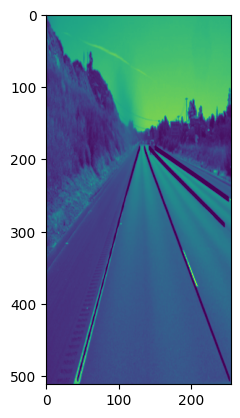

In [8]:

plt.imshow(test_dataset[0][1].squeeze().cpu())

In [9]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'),)
test_loader = DataLoader(test_dataset, batch_size=batch_size, generator=torch.Generator(device='cuda'),)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1).to(device)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1).to(device)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1).to(device)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1).to(device)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1).to(device)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1).to(device)
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=4, kernel_size=3, padding=1).to(device)
        self.conv8 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3, padding=1).to(device)

    def forward(self, image):
        image = relu(self.conv1(image))
        image = relu(self.conv2(image))
        image = relu(self.conv3(image))
        image = relu(self.conv4(image))
        image = relu(self.conv5(image))
        image = relu(self.conv6(image))
        image = relu(self.conv7(image))
        image = relu(self.conv8(image))
        return image
    

In [11]:
def train_one_epoch(
    loader, 
    model,
    optim,
    loss_fn,
    
    epoch_num=-1, 
    ):

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch_num}: train", leave=True)
    model.train()


    loss_sum = 0.0
    

    # train loop
    for i, batch in loop:
        image, image_with_lanes = batch
        image = image.to(device)
        image_with_lanes = image_with_lanes.to(device)

        # forward pass
        outputs = model(image)

        

        # loss calculation
        loss = loss_fn(outputs, image_with_lanes)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_sum += loss.item()

        loop.set_postfix({"loss": float(loss)})
    
    
    print('Train loss:', float(loss_sum) / (i+1))
    
    

    return loss_sum / (i+1)



def val_one_epoch(
    model,
    loader,
    loss_fn,
    
    epoch_num=-1,
):

    loop = tqdm(enumerate(loader, 1), total=len(loader), desc=f"Epoch {epoch_num}: val", leave=True)
    loss_sum = 0.0
    with torch.no_grad():
        model.eval()
        # save 1 picture each batch
        for i, batch in loop:
            image, image_with_lanes = batch
            image = image.to(device)
            image_with_lanes = image_with_lanes.to(device)
            
            # forward pass
            outputs = model(image)
            
            # loss calculation
            loss = loss_fn(outputs, image_with_lanes)
            
            loss_sum += loss.item()

            loop.set_postfix({"loss": float(loss_sum)})
    print('Val loss:',float(loss_sum) / (i+1))

    return loss_sum / (i+1)



def train(
    train_dataloader,
    val_dataloader,
    model,
    optim,
    loss_fn,
    epochs,
    ckpt_path="best.pt",
    
):
    
    # keep previous best loss to receive the 'best.pth' model with the least val loss
    prev_best = float("inf")

    losses_train = []
    losses_val = []
    counter = 0
    for epoch in range(epochs):
        # train
        train_loss = train_one_epoch(
            train_dataloader,
            model,
            optim,
            loss_fn,
            epoch_num=epoch,
            )
        
        
        losses_train.append(train_loss)

        # validate
        val_loss = val_one_epoch(
            model,
            val_dataloader,
            loss_fn,
            epoch_num=epoch,
            )
        
        losses_val.append(val_loss)

        # model and model's output saving because intermediate results of Colorization
        # might be better than final
        


        if val_loss < prev_best:
            prev_best = val_loss
            torch.save(model, ckpt_path)
            counter = 0
        else:
            counter+=1

        if counter >= 3:
            break

    return losses_train, losses_val


In [12]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()
epochs = 10
losses_train, losses_val = train(train_loader, test_loader, model, optimizer, loss, epochs)

Epoch 0: train: 100%|██████████| 227/227 [02:03<00:00,  1.84it/s, loss=6.9e+3] 


Train loss: 22667.173176366327


Epoch 0: val: 100%|██████████| 174/174 [01:34<00:00,  1.84it/s, loss=1.24e+6]


Val loss: 7064.271446707589


Epoch 1: train: 100%|██████████| 227/227 [01:43<00:00,  2.20it/s, loss=6.81e+3]


Train loss: 7042.097494923596


Epoch 1: val: 100%|██████████| 174/174 [00:51<00:00,  3.35it/s, loss=1.04e+6]


Val loss: 5955.468221261161


Epoch 2: train: 100%|██████████| 227/227 [01:47<00:00,  2.10it/s, loss=7.46e+3]


Train loss: 6589.841508638491


Epoch 2: val: 100%|██████████| 174/174 [00:52<00:00,  3.31it/s, loss=9.83e+5]


Val loss: 5618.134666573661


Epoch 3: train: 100%|██████████| 227/227 [01:47<00:00,  2.11it/s, loss=6.54e+3]


Train loss: 6394.07958984375


Epoch 3: val: 100%|██████████| 174/174 [00:51<00:00,  3.37it/s, loss=9.57e+5]


Val loss: 5467.915475725446


Epoch 4: train: 100%|██████████| 227/227 [01:48<00:00,  2.08it/s, loss=6.22e+3]


Train loss: 6271.17532523403


Epoch 4: val: 100%|██████████| 174/174 [00:53<00:00,  3.26it/s, loss=9.47e+5]


Val loss: 5411.559644252232


Epoch 5: train: 100%|██████████| 227/227 [01:46<00:00,  2.12it/s, loss=5.25e+3]


Train loss: 6124.182262269411


Epoch 5: val: 100%|██████████| 174/174 [00:52<00:00,  3.34it/s, loss=9.15e+5]


Val loss: 5230.720707310268


Epoch 6: train: 100%|██████████| 227/227 [01:47<00:00,  2.11it/s, loss=6.48e+3]


Train loss: 6003.152094231828


Epoch 6: val: 100%|██████████| 174/174 [00:53<00:00,  3.24it/s, loss=8.96e+5]


Val loss: 5118.436173270089


Epoch 7: train: 100%|██████████| 227/227 [01:49<00:00,  2.08it/s, loss=6.94e+3]


Train loss: 5959.043897990088


Epoch 7: val: 100%|██████████| 174/174 [00:52<00:00,  3.33it/s, loss=8.49e+5]


Val loss: 4852.764736328125


Epoch 8: train: 100%|██████████| 227/227 [01:47<00:00,  2.11it/s, loss=5.01e+3]


Train loss: 5830.10863504956


Epoch 8: val: 100%|██████████| 174/174 [00:53<00:00,  3.26it/s, loss=8.62e+5]


Val loss: 4926.9234228515625


Epoch 9: train: 100%|██████████| 227/227 [01:48<00:00,  2.10it/s, loss=5.86e+3]


Train loss: 5735.655600392346


Epoch 9: val: 100%|██████████| 174/174 [00:53<00:00,  3.26it/s, loss=8.06e+5]

Val loss: 4605.757307477678


In [13]:
image, image_with_lanes = test_dataset[0]

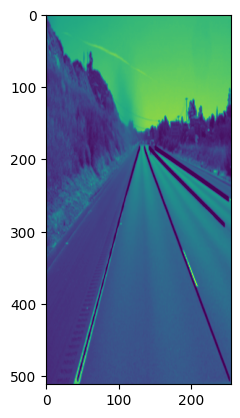

In [14]:
plt.imshow(image_with_lanes.squeeze().cpu())

In [15]:
model.eval()
image_from_model = model(image)
image_from_model.shape

torch.Size([1, 512, 256])

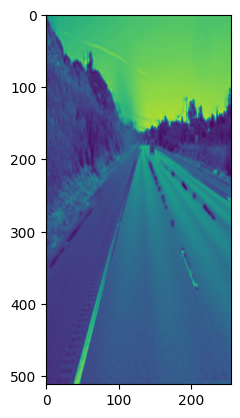

In [16]:
plt.imshow(image_from_model.squeeze().cpu().detach().numpy())